# Measures of socioeconomic position (Part 2)

Author: Mauro Antonio León Payano

In [7]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

def redshift_conn():
    config = {}
    config["redshift_user"] = "xxxxx"
    config["redshift_password"] = "xxxx"
    config["redshift_host"] = "xxxxx"
    config["redshift_port"] = "xxxx"
    config["redshift_database"] = "xxxx"
    uri = 'redshift+psycopg2://{p[redshift_user]}:{p[redshift_password]}@{p[redshift_host]}:{p[redshift_port]}/{p[redshift_database]}'\
    .format(p=config)
    db_credentials = (uri)
    engine = sa.create_engine(db_credentials)
    Session = sessionmaker(bind=engine)
    return Session(), uri

conn, uri = redshift_conn()

## List the existing tables in the RedShift database


In [83]:
query_table = """
select distinct(tablename) from pg_table_def where schemaname = 'public';
"""
pd.read_sql(query_table, conn.bind)

,tablename
0,cell
1,mcc
2,movement
3,ref_cell
4,transaction
5,transaction_amp
6,transaction_puc


## Count valid transactions

In [77]:
query_count_transactions = """
SELECT COUNT(*)
FROM transaction
WHERE amount_sol>0
AND mccg = 28;
"""

pd.read_sql(query_count_transactions, conn.bind)

,count
0,108515


# Create Table transaction_amp (Average Monthy Purchase)
### 1. Drop preexisting table transaction_amp

In [78]:
query_remove_table = """
DROP TABLE transaction_amp;
"""
try:
    pd.read_sql(query_remove_table, conn.bind)
except:
    print("End execute drop table")

End execute drop table


### 2. Create transaction_amp table from a select statement

In [82]:
#Extract column date in format YYYYMM
query_create_table_amp = """
CREATE TABLE transaction_amp AS (
SELECT t.row, t.client_id, t.time_count, t.amount_total, t.amp, sum(t.amp) over (order by t.row rows unbounded preceding) as cum_sum
    FROM (
        SELECT row_number() over (order by amp) as row, p.client_id, p.time_count, p.amount_total, 
        p.amount_total/p.time_count as amp
        FROM (
            SELECT x.client_id, count(distinct(x.weeknum)) as time_count, sum(x.amount_sol) as amount_total
            FROM (
                SELECT y.client_id, TO_CHAR(y.date, 'YYYYMM') as weeknum, y.amount_sol, y.mccg
                FROM transaction AS y
                WHERE y.amount_sol > 0.0
                AND y.mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
            ) AS x
            GROUP BY x.client_id
        ) AS p
        ORDER BY amp ASC
    ) AS t)
"""
try:
    pd.read_sql(query_create_table_amp, conn.bind)
except:
    print("End execute query")

End execute query


### 3. Add C(f) column into table transaction_amp

In [85]:
#UPDATE CREATE COLUMN C(f)
update_add_column = """
ALTER TABLE transaction_amp
ADD c_f numeric(38,4)
"""
try:
    pd.read_sql(update_add_column, conn.bind)
except:
    print("Add column into table transaction_amp")

Add column into table transaction_amp


### 4. List the columns in table transaction_amp

In [86]:
query_test_create_table = """
select "column", type, encoding, distkey, sortkey, "notnull" 
from pg_table_def 
where tablename = 'transaction_amp'
"""
pd.read_sql(query_test_create_table, conn.bind)

,column,type,encoding,distkey,sortkey,notnull
0,row,bigint,lzo,False,0,False
1,client_id,character varying(256),lzo,False,0,False
2,time_count,bigint,lzo,False,0,False
3,amount_total,"numeric(38,0)",lzo,False,0,False
4,amp,"numeric(38,4)",lzo,False,0,False
5,cum_sum,"numeric(38,4)",lzo,False,0,False
6,c_f,"numeric(38,4)",lzo,False,0,False


### 5. Calculate the distribution column C(f)


In [87]:
set_value_column="""
UPDATE transaction_amp
SET c_f = cum_sum/(SELECT SUM(amp) AS sum_amp 
    FROM transaction_amp)
"""
try:
    pd.read_sql(set_value_column, conn.bind)
except:
    print("Update column c_f")

Update column c_f


### 6. Classification of users into classes

#### 6.1. Add class column

In [107]:
## Add columm class
#UPDATE CREATE COLUMN C(f)
update_add_column = """
ALTER TABLE transaction_amp
ADD class bigint
"""
try:
    pd.read_sql(update_add_column, conn.bind)
except:
    print("Add column into table transaction_amp")

Add column into table transaction_amp


#### 6.2. Assign the socioeconomic class to each record 

For classification, consider which:
\begin{equation*}
\left (\sum_{u=1} P_u /n \right)
\end{equation*}
is the same in each class. Where n = 1806836 is the total of transations

In [153]:
## Assign class 1
set_class_1_table = """
UPDATE transaction_amp
SET class = 1
WHERE cum_sum >= 0 AND cum_sum <= 1.992676e+08
"""
try:
    pd.read_sql(set_class_1_table, conn.bind)
except:
    print("Update column class 1")
    
## Assign class 2
set_class_2_table = """
UPDATE transaction_amp
SET class = 2
WHERE cum_sum > 1.992676e+08 AND cum_sum <= 1.992676e+08*2
"""
try:
    pd.read_sql(set_class_2_table, conn.bind)
except:
    print("Update column class 2")

## Assign class 3
set_class_3_table = """
UPDATE transaction_amp
SET class = 3
WHERE cum_sum > 1.992676e+08*2 AND cum_sum <= 1.992676e+08*3
"""
try:
    pd.read_sql(set_class_3_table, conn.bind)
except:
    print("Update column class 3")

## Assign class 4
set_class_4_table = """
UPDATE transaction_amp
SET class = 4
WHERE cum_sum > 1.992676e+08*3 AND cum_sum <= 1.992676e+08*4
"""
try:
    pd.read_sql(set_class_4_table, conn.bind)
except:
    print("Update column class 4")

## Assign class 5
set_class_5_table = """
UPDATE transaction_amp
SET class = 5
WHERE cum_sum > 1.992676e+08*4 AND cum_sum <= 1.992676e+08*5
"""
try:
    pd.read_sql(set_class_5_table, conn.bind)
except:
    print("Update column class 5")

## Assign class 6
set_class_6_table = """
UPDATE transaction_amp
SET class = 6
WHERE cum_sum > 1.992676e+08*5 AND cum_sum <= 1.992676e+08*6
"""
try:
    pd.read_sql(set_class_6_table, conn.bind)
except:
    print("Update column class 6")

## Assign class 7
set_class_7_table = """
UPDATE transaction_amp
SET class = 7
WHERE cum_sum > 1.992676e+08*6 AND cum_sum <= 1.992676e+08*7
"""
try:
    pd.read_sql(set_class_7_table, conn.bind)
except:
    print("Update column class 7")
    
## Assign class 8
set_class_8_table = """
UPDATE transaction_amp
SET class = 8
WHERE cum_sum > 1.992676e+08*7 AND cum_sum <= 1.992676e+08*8
"""
try:
    pd.read_sql(set_class_8_table, conn.bind)
except:
    print("Update column class 8")
    
## Assign class 9
set_class_9_table = """
UPDATE transaction_amp
SET class = 9
WHERE cum_sum > 1.992676e+08*8
"""
try:
    pd.read_sql(set_class_9_table, conn.bind)
except:
    print("Update column class 9")

Update column class 2


query_count_amp = """
SELECT COUNT(*)
FROM transaction_amp
"""
pd.read_sql(query_count_amp, conn.bind)

1806836

#### 6.3. Select the records in the table transaction_amp

In [10]:
select_transaction_amp = """
SELECT *
FROM transaction_amp
LIMIT 10
"""
pd.read_sql(select_transaction_amp, conn.bind)

,row,client_id,time_count,amount_total,amp,cum_sum,c_f,class
0,2,z4mNGjjEuxM=,1,1.0,1.0,2.0,0.0,1
1,4,Hwua3H8xbh0=,1,1.0,1.0,4.0,0.0,1
2,6,Itj9o8RMMOk=,1,1.0,1.0,6.0,0.0,1
3,8,3CLC9DpdPnY=,1,1.0,1.0,8.0,0.0,1
4,10,JfF9kq49IHI=,1,1.0,1.0,10.0,0.0,1
5,12,zqe5rHlpIKk=,1,1.0,1.0,12.0,0.0,1
6,14,DJFqgpql/jw=,1,1.0,1.0,14.0,0.0,1
7,16,+SHU2fflLzI=,1,1.0,1.0,16.0,0.0,1
8,18,WC9q8NJAVJ8=,1,1.0,1.0,18.0,0.0,1
9,20,RW6qJpD0ICM=,1,1.0,1.0,20.0,0.0,1


#### 6.4. Schematic of user partitions
Use partitions into 9 socioeconomic classes by using the cumulative AMP function C(f)

In [18]:
select_all_transaction_amp = """
SELECT client_id, c_f, class
FROM transaction_amp
ORDER BY amp
"""
df = pd.read_sql(select_all_transaction_amp, conn.bind)

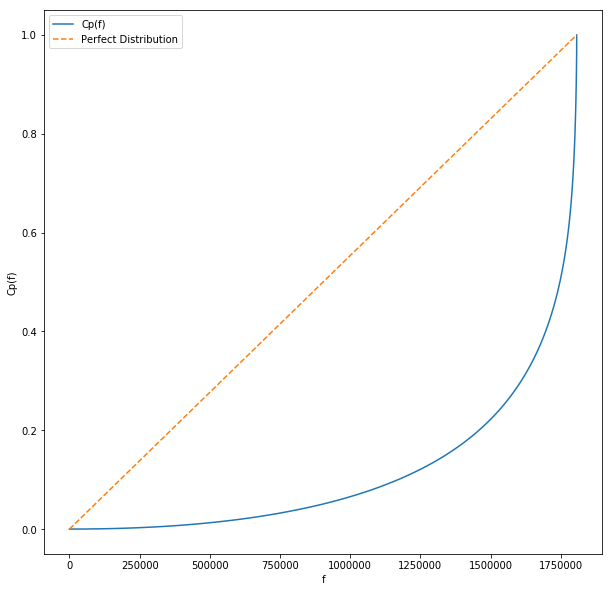

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

distr_fraction_people = np.array(df['c_f'])
x = np.linspace(0,len(distr_fraction_people));
y = np.linspace(0,1);
plt.figure(figsize=(10,10))
distr_fraction_people_line = plt.plot(distr_fraction_people, label="Cp(f)")
distr_perfect_line = plt.plot(x,y,linestyle='--', label="Perfect Distribution");
plt.legend(loc='upper left')

plt.ylabel('Cp(f)')
plt.xlabel('f')
plt.show()

# Create Table transaction_puc (Purchase User By Category)

### 1. Drop preexisting table transaction_puc

In [ ]:
query_remove_table = """
DROP TABLE transaction_puc;
"""
try:
    pd.read_sql(query_remove_table, conn.bind)
except:
    print("Drop table transaction_puc")

### 2. Create transaction_puc table from a select statement

\begin{equation*}
\left (r(c,u) = \frac{m_u^{c}}{\sum_{c} m_u^{c}} \right)
\end{equation*}


In [200]:
#Sum by category c_i
query_create_table_puc = """
CREATE TABLE transaction_puc AS (
    SELECT S.client_id, L.mccg, L.amount_mccg_total, S.amount_total, 
            CASE WHEN S.amount_total=0 then 0 ELSE L.amount_mccg_total/S.amount_total END as PUC
    FROM (
        SELECT client_id, sum(amount_sol) AS amount_total
        FROM transaction
        WHERE amount_sol > 0.0
        AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
        GROUP BY client_id) S
            INNER JOIN (
                SELECT client_id, mccg, sum(amount_sol) AS amount_mccg_total
                FROM transaction
                WHERE amount_sol > 0.0
                AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
                GROUP BY client_id, mccg) L
            ON S.client_id = L.client_id
        ORDER BY S.client_id
)
"""
try:
    pd.read_sql(query_create_table_puc, conn.bind)
except:
    print("End execute query")

End execute query


### 3. Select the records in the table transaction_puc

In [20]:
select_transaction_puc = """
SELECT *
FROM transaction_puc
ORDER BY client_id
LIMIT 10
"""
pd.read_sql(select_transaction_puc, conn.bind)

,client_id,mccg,amount_mccg_total,amount_total,puc
0,+++AhJk2QJM=,24,150.0,943.0,0.1590
1,+++AhJk2QJM=,22,787.0,943.0,0.8345
2,+++AhJk2QJM=,23,6.0,943.0,0.0063
3,+++el3L/5Wo=,24,130.0,130.0,1.0000
4,+++g8j9k+5A=,17,1315.0,11330.0,0.1160
5,+++g8j9k+5A=,26,156.0,11330.0,0.0137
6,+++g8j9k+5A=,6,126.0,11330.0,0.0111
7,+++g8j9k+5A=,8,2002.0,11330.0,0.1766
8,+++g8j9k+5A=,11,1469.0,11330.0,0.1296
9,+++g8j9k+5A=,24,200.0,11330.0,0.0176


In [ ]:
query_description = """
select query, trim(querytxt) as sqlquery, starttime, endtime
from stl_query
order by query desc limit 5;
"""
df = pd.read_sql(query_description, conn.bind)
df